# Generate Topic Data

In [11]:
import sys
import os
parent_dir = "/Users/jeong-yeojin/Desktop/SpLSI/pycvxcluster"
os.chdir(parent_dir)
sys.path.append(parent_dir)
from src.pycvxcluster.pycvxcluster import *
sys.path.append("./src/")
import pycvxcluster.pycvxcluster

ModuleNotFoundError: No module named 'pycvxcluster.algos'

In [20]:
import numpy as np
from numpy.linalg import norm, svd, solve, qr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
import scipy
from scipy.sparse import csr_matrix
import networkx as nx
#from netgraph import Graph
#from netgraph import get_sugiyama_layout

def get_initial_centers(val, centers):
    quantiles = []
    for i in range(centers):
        quantiles.append(i * int(val.shape[0]/centers))
    return quantiles

def align_order(k, K):
    order = np.zeros(K, dtype=int)
    order[np.where(np.arange(K) != k)[0]] = np.random.choice(np.arange(1, K), K-1, replace=False)
    order[k] = 0
    return order

def reorder_with_noise(v, order, K, r):
    u = np.random.rand()
    if u < r:
        return v[order[np.random.choice(range(K), K, replace=False)]]
    else:
        sorted_row = np.sort(v)[::-1]
        return sorted_row[order]
    
def sample_MN(p, N):
    return np.random.multinomial(N, p, size=1)

def generate_graph(N, n, p, K, r):
    np.random.seed(127)
    coords = np.zeros((n, 2))
    coords[:, 0] = np.random.uniform(-3, 3, n)
    coords[:, 1] = np.random.uniform(-3, 3, n)

    cluster_obj = KMeans(n_clusters=20, init=coords[get_initial_centers(coords, 20), :], n_init=1)
    grps = cluster_obj.fit_predict(coords)

    df = pd.DataFrame(coords, columns=['x','y'])
    df['grp'] = grps % K
    return df

def generate_W(df, N, n, p, K, r):
    W = np.zeros((K, n))
    for k in range(K):
        alpha = np.random.uniform(0.1, 0.3, K)
        cluster_size = df[df['grp'] == k].shape[0]
        order = align_order(k, K)
        inds = df['grp'] == k
        W[:, inds] = np.transpose(np.apply_along_axis(reorder_with_noise, 1, np.random.dirichlet(alpha, size=cluster_size), order, K, r))

        # generate pure doc 
        cano_ind = np.random.choice(np.where(inds)[0], 1)
        W[:, cano_ind] = np.eye(K)[0, :].reshape(K,1)
    return W

def generate_A(df, N, n, p, K, r):
    A = np.random.uniform(0, 1, size=(p, K))

    # generate pure word
    cano_ind = np.random.choice(np.arange(p), K, replace=False)
    A[cano_ind, :] = np.eye(K)
    A = np.apply_along_axis(lambda x: x / np.sum(x), 0, A)
    return A

def generate_data(N, n, p, K, r):
    df = generate_graph(N, n, p , K, r)
    W = generate_W(df, N, n, p , K, r)
    A = generate_A(df, N, n, p , K, r)
    D0 = np.dot(A, W)
    D = np.apply_along_axis(sample_MN, 0, D0, N).reshape(p,n)
    assert np.sum(np.apply_along_axis(np.sum, 0, D)!=N) == 0
    D = D/N
    return df, W, A, D

def plot_scatter(df):
    unique_groups = df['grp'].unique()
    cmap = plt.get_cmap('Set3', len(unique_groups))
    colors = [cmap(i) for i in range(len(unique_groups))]
    
    for group, color in zip(unique_groups, colors):
        grp_data = df[df['grp'] == group]
        plt.scatter(grp_data['x'], grp_data['y'], label=group, color=color)


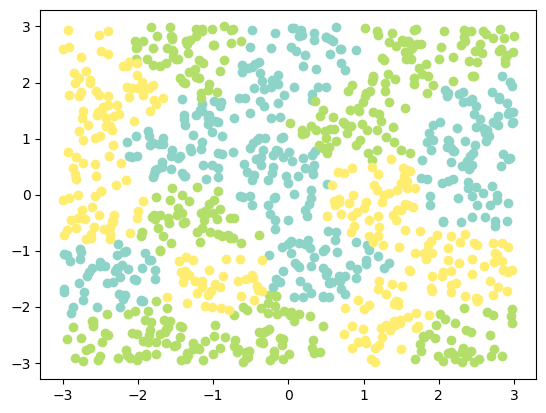

In [16]:
N = 100 # doc length
n = 1000 # number of nodes
p = 30 # vocab size
K = 3 # number of topics
r = 0.05 # heterogeneity parameter
m = 5 # number of neighbors to be considered in weights
phi = 0.1 # weight parameter

df, W, A, D = generate_data(N, n, p , K, r)
plot_scatter(df)

# MST Folds / Matrix Denoising via Iterative Convex Clustering

Source node is 201
Fold1 size is 503
Fold2 size is 497


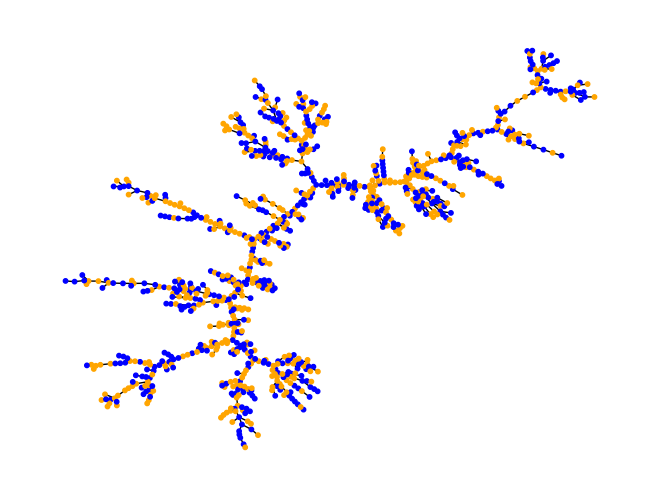

In [17]:
def generate_weights(df, K, nearest_n, phi):
    K = rbf_kernel(df[['x','y']], gamma = phi)
    np.fill_diagonal(K, 0)
    weights = np.zeros_like(K)

    for i in range(K.shape[0]):
        top_indices = np.argpartition(K[i], -nearest_n)[-nearest_n:]
        weights[i, top_indices] = K[i, top_indices]
        
    weights = (weights+weights.T)/2  
    # Adj = csr_matrix(weights)
    return weights

def generate_graph_from_weights(df, weights, n):
    np.random.seed(127)
    G = nx.Graph()
    for node in range(n):
        x = df['x'].iloc[node]
        y = df['y'].iloc[node]
        G.add_node(node, pos=(x, y))
    
    for node1 in G.nodes:
        for node2 in G.nodes:
            if node1 < node2:
                #pos1 = G.nodes[node1]['pos']
                #pos2 = G.nodes[node2]['pos']
                w = weights[node1,node2]
                #dist = norm(np.array(pos1) - np.array(pos2))
                if w > 0:
                    G.add_edge(node1, node2, weight=w)
    return G

def get_mst_path(G):
    mst = nx.minimum_spanning_tree(G)
    path = dict(nx.all_pairs_shortest_path_length(mst))
    return mst, path

def generate_mst(df, n, K, nearest_n, phi):
    weights = generate_weights(df, K, nearest_n, phi)
    G = generate_graph_from_weights(df, weights, n)
    mst, path = get_mst_path(G)
    return G, mst, path

def get_parent_node(mst, srn, nodenum):
    neighs = list(mst.adj[nodenum].keys())
    length_to_srn = [path[neigh][srn] for neigh in neighs]
    parent = neighs[np.argmin(length_to_srn)]
    return parent

def get_folds(path, n, plot_tree=True):
    np.random.seed(127)
    srn = np.random.choice(range(n),1)[0]
    print(f"Source node is {srn}")

    fold1 = []
    fold2 = []
    colors = []
    for key, value in path[srn].items():
        if (value%2)==0:
            fold1.append(key)
            colors.append("orange")
        elif (value%2)==1:
            fold2.append(key)
            colors.append("blue")
        else:
            colors.append("red")
    len1 = len(fold1)
    len2 = len(fold2)
    print(f"Fold1 size is {len1}")
    print(f"Fold2 size is {len2}")
    if plot_tree:
        nx.draw_kamada_kawai(mst, node_color = colors, node_size=10)
    return srn, fold1, fold2

def get_colors(df):
    grps = list(set(df['grp']))
    colors = []
    color_palette = ['cyan','yellow','greenyellow','coral','plum']
    colormap = {value: color for value, color in zip(grps, color_palette[:len(grps)])}

    for value in df['grp']:
        colors.append(colormap[value])
    return colors

def plot_2d_tree(colors, G, mst):
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels=False, node_size=10, node_color=colors, edge_color='gray', alpha=0.6)
    nx.draw(mst, pos, with_labels=False, node_size=10, node_color=colors, edge_color='r', alpha=1)
    plt.show()

G, mst, path = generate_mst(df, n, K, 5, 0.1)
srn, fold1, fold2 = get_folds(path, n)
folds = {0:fold1, 1:fold2}

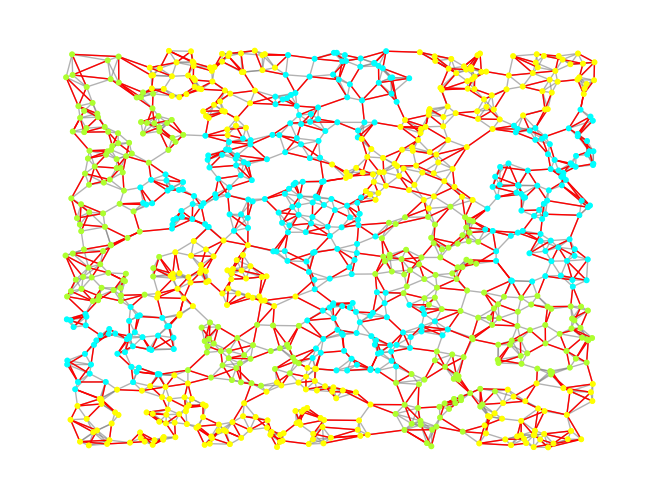

In [19]:
colors = get_colors(df)
# Plot the random graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=10, node_color=colors, edge_color='gray', alpha=0.6)

# Plot the minimum spanning tree in red
nx.draw(mst, pos, with_labels=False, node_size=10, node_color=colors, edge_color='r', alpha=1)

plt.show()

In [ ]:
def interpolate_X(X, foldnum):
    fold = folds[foldnum]
    
    for node in fold:
        parent = get_parent_node(mst, srn, node)
        X[node,:] = X[parent,:]
    return X

def update_U_tilde(X, L, V, weights, folds, lambd_grid, n, K):
    U_best_comb = np.zeros((n,K))
    lambds_best = {}

    for j in folds.keys():
        fold = folds[j]
        X_tilde = interpolate_X(X, j)
        X_j = X_tilde[fold,:]

        best_err = float("inf")
        U_best = None
        lambd_best = 0
        
        for lambd in lambd_grid:
            U_hat = cluster_algorithm(X_tilde, lambd, weights)
            M = np.dot(np.dot(U_hat, L), V)
            err = norm(X_j-M[fold,:])
            if err < best_err:
                lambd_best = lambd
                U_best = U_hat

        U_best_comb[fold,:] = U_best
        lambds_best[j] = lambd_best

    best_err = float("inf")
    lambd_cv = 0

    for lambd in lambd_grid:
        U_hat_full = cluster_algorithm(X, lambd, weights)
        err = norm(U_hat_full-U_best_comb)
        if err < best_err:
            lambd_cv = lambd
            U_cv = U_hat_full
    Q, R = qr(U_cv)
    return Q, lambd_cv

def update_V_tilde(X, U_tilde):
    V_hat = np.dot(X.T, U_tilde)
    Q, R = qr(V_hat)
    return Q

def update_L_tilde(X, U_tilde, V_tilde):
    L_tilde = np.dot(np.dot(U_tilde.T, X), V_tilde)
    return L_tilde

def run_iter_cvx(X, L, V, weights, folds, lambd_grid, n, K, eps):
    U, L, V = svds(X, k=K)
    thres = 1
    while thres > eps:
        UUT_old = np.dot(U, U.T)
        VVT_old = np.dot(V, V.T)

        U, lambd = update_U_tilde(X, L, V, weights, folds, lambd_grid, n, K)
        V = update_V_tilde(X, U)
        L = update_L_tilde(X, U, V)

        UUT = np.dot(U, U.T)
        VVT = np.dot(V, V.T)
        thres = np.max(norm(UUT-UUT_old)**2, norm(VVT-VVT_old)**2)
    return U, lambd


# SPOC Algorithm

In [ ]:
from scipy.optimize import linear_sum_assignment

def preprocess_U(U, K):
    for k in range(K):
        if U[0, k] < 0:
            U[:, k] = -1 * U[:, k]
    return U

def proj_simplex(v):
    n = len(v)
    if np.sum(v) == 1 and np.all(v >= 0):
        return v
    u = np.sort(v)[::-1]
    rho = np.max(np.where(u * np.arange(1, n + 1) > (np.cumsum(u) - 1)))
    theta = (np.cumsum(u) - 1) / rho
    w = np.maximum(v - theta, 0)
    return w

def get_component_mapping(stats_1, stats_2):
    similarity = np.dot(stats_1, stats_2.T)
    cost_matrix = -similarity
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    P = np.zeros_like(cost_matrix)
    P[row_ind, col_ind] = 1
    return P

def fit_SPOC(df, D, W, U, K, w, method="spatial"):
    if method != "spatial":
        print("vanilla")
        _, _, U = svd(D, full_matrices=False)
        U = U[:K, :].T

    J = []
    S = preprocess_U(U.T, K)  # K x n
    # Run SPA
    for t in range(K):
        maxind = np.argmax(np.linalg.norm(S, axis=0))
        s = np.reshape(S[:, maxind], (K, 1))
        S1 = (np.eye(K) - np.dot(s, s.T) / np.linalg.norm(s)**2).dot(S)
        S = S1
        J.append(maxind)
    # Get \hat{H} and \hat{H}
    H_hat = U[J, :]
    W_hat = np.dot(U, solve(H_hat, np.eye(K), tol=1e-07))
    # Postprocess
    # W_hat = np.apply_along_axis(proj_simplex, 1, W_hat)
    P = get_component_mapping(W_hat.T, W.T)
    W_hat = np.dot(W_hat, P)
    # Results
    n = W_hat.shape[0]
    clt = np.argmax(W_hat, axis=1)
    accuracy = np.sum(clt == df['grp_new'].values) / n
    print(accuracy)
    err = norm(W - W_hat, ord='fro')
    print(err)
    return {'acc': accuracy, 'f.err': err, 'What': W_hat}


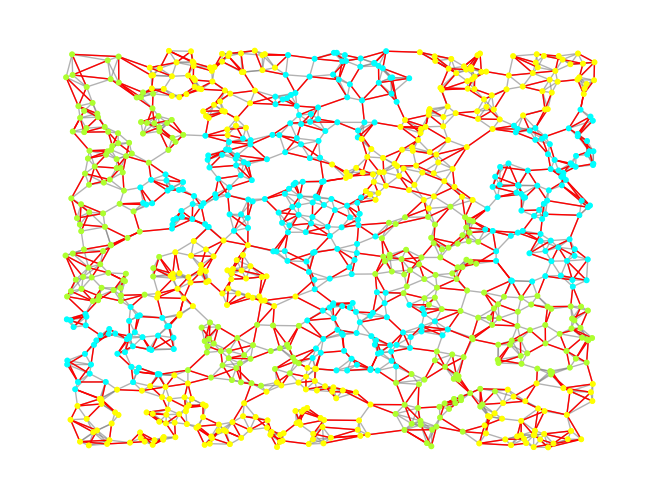

In [ ]:
# Plot the random graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=10, node_color=colors, edge_color='gray', alpha=0.6)

# Plot the minimum spanning tree in red
nx.draw(mst, pos, with_labels=False, node_size=10, node_color=colors, edge_color='r', alpha=1)

plt.show()